# Movie recommender using cosine similarity

Includes a basic GUI for movie recommendations.

In [34]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

*Prerequisite*: Download data from [IMDB](https://datasets.imdbws.com/) - only need the title basics and title ratings tables

In [1]:
# file name
file_path = '/data/movies/'
title_basics = 'title_basics_071521.tsv'
title_ratings = 'title_ratings_071521.tsv'

In [4]:
# import tsv to df
df_title_basics = pd.read_table(file_path+title_basics, sep='\t')

/Users/mikegoodman/Documents/developer/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df_title_ratings = pd.read_table(file_path+title_ratings, sep='\t')

In [7]:
# data cleansing
df_title_basics_clean = df_title_basics.drop(columns = ['endYear', 'originalTitle', 'isAdult', 'runtimeMinutes'])

df_title_basics_clean = df_title_basics_clean[df_title_basics_clean['startYear']!='\\N']
df_title_basics_clean = df_title_basics_clean[df_title_basics_clean['genres']!='\\N']
df_title_basics_clean

,tconst,titleType,primaryTitle,startYear,genres
0,tt0000001,short,Carmencita,1894,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,1892,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,1892,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,1892,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,1893,"Comedy,Short"
...,...,...,...,...,...
8090441,tt9916848,tvEpisode,Episode #3.17,2010,"Action,Drama,Family"
8090442,tt9916850,tvEpisode,Episode #3.19,2010,"Action,Drama,Family"
8090443,tt9916852,tvEpisode,Episode #3.20,2010,"Action,Drama,Family"
8090444,tt9916856,short,The Wind,2015,Short


In [8]:
# filter for only movies
df_movies = df_title_basics_clean[df_title_basics_clean['titleType'] == 'movie']

In [9]:
# set data types
df_movies_clean = df_movies.astype({'tconst':'str', 'titleType':'str', 'primaryTitle': 'str', 'startYear': 'int'})

In [10]:
# split genres into list
df_movies_clean['genres'] = df_movies_clean['genres'].apply(lambda x: x.split(","))
df_movies_clean.head()

,tconst,titleType,primaryTitle,startYear,genres
570,tt0000574,movie,The Story of the Kelly Gang,1906,"[Action, Adventure, Biography]"
587,tt0000591,movie,The Prodigal Son,1907,[Drama]
610,tt0000615,movie,Robbery Under Arms,1907,[Drama]
625,tt0000630,movie,Hamlet,1908,[Drama]
668,tt0000675,movie,Don Quijote,1908,[Drama]


In [11]:
# merge ratings data onto main df
df_movies_ratings = df_movies_clean.merge(df_title_ratings, left_on='tconst', right_on='tconst')
df_movies_ratings = df_movies_ratings[df_movies_ratings['startYear'] >= 1980]
df_movies_ratings = df_movies_ratings[df_movies_ratings['numVotes'] >= 500]
df_movies_ratings['fullTitle'] = df_movies_ratings['primaryTitle'] + ' (' + df_movies_ratings['startYear'].astype(str) + ')'
df_movies_ratings = df_movies_ratings.reset_index(drop=True)
df_movies_ratings.head()

,tconst,titleType,primaryTitle,startYear,genres,averageRating,numVotes,fullTitle
0,tt0035423,movie,Kate & Leopold,2001,"[Comedy, Fantasy, Romance]",6.4,80225,Kate & Leopold (2001)
1,tt0038687,movie,Let There Be Light,1980,"[Documentary, War]",7.5,1691,Let There Be Light (1980)
2,tt0066498,movie,The Ear,1990,"[Drama, Thriller]",7.8,2607,The Ear (1990)
3,tt0067100,movie,Firecracker,1981,"[Action, Drama, Thriller]",5.6,586,Firecracker (1981)
4,tt0067625,movie,Trial on the Road,1986,"[Drama, War]",7.9,2070,Trial on the Road (1986)


In [12]:
from collections import Counter

genres_counts = Counter(g for genres in df_movies_ratings['genres'] for g in genres)
print(f"There are {len(genres_counts)} genre labels.")
genres_counts

There are 24 genre labels.


Counter({'Comedy': 13534,
         'Fantasy': 2038,
         'Romance': 6279,
         'Documentary': 2590,
         'War': 722,
         'Drama': 20442,
         'Thriller': 5982,
         'Action': 7074,
         'Crime': 5588,
         'Horror': 4791,
         'Sci-Fi': 1852,
         'Adventure': 3651,
         'Mystery': 2651,
         'Animation': 1316,
         'Family': 1587,
         'History': 1316,
         'Music': 1242,
         'Adult': 16,
         'Biography': 1956,
         'Musical': 441,
         'Sport': 772,
         'Western': 164,
         'News': 47,
         'Reality-TV': 1})

In [13]:
# 2 ways to get movie decade
def get_decade(year):
    year = str(year)
    decade_prefix = year[0:3] # get first 3 digits of year
    decade = f'{decade_prefix}0' # append 0 at the end
    return int(decade)

def round_down(year):
    return year - (year%10)

In [14]:
df_movies_ratings['decade'] = df_movies_ratings['startYear'].apply(round_down)
df_movies_ratings.head()

,tconst,titleType,primaryTitle,startYear,genres,averageRating,numVotes,fullTitle,decade
0,tt0035423,movie,Kate & Leopold,2001,"[Comedy, Fantasy, Romance]",6.4,80225,Kate & Leopold (2001),2000
1,tt0038687,movie,Let There Be Light,1980,"[Documentary, War]",7.5,1691,Let There Be Light (1980),1980
2,tt0066498,movie,The Ear,1990,"[Drama, Thriller]",7.8,2607,The Ear (1990),1990
3,tt0067100,movie,Firecracker,1981,"[Action, Drama, Thriller]",5.6,586,Firecracker (1981),1980
4,tt0067625,movie,Trial on the Road,1986,"[Drama, War]",7.9,2070,Trial on the Road (1986),1980


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '1980'),
  Text(1, 0, '1990'),
  Text(2, 0, '2000'),
  Text(3, 0, '2010'),
  Text(4, 0, '2020')])

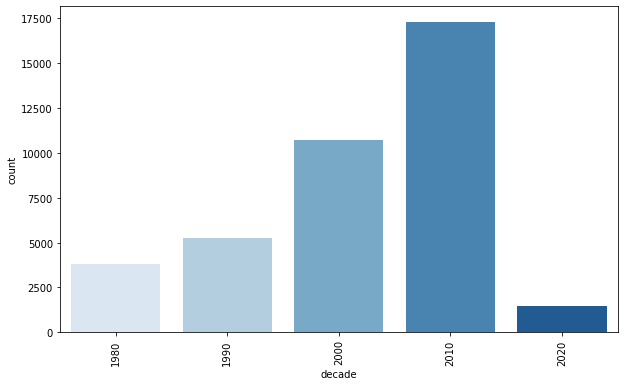

In [15]:
plt.figure(figsize=(10,6))
sns.countplot(df_movies_ratings['decade'], palette='Blues')
plt.xticks(rotation=90)

In [16]:
# generate features based on genres
genres = list(genres_counts.keys())

for g in genres:
    df_movies_ratings[g] = df_movies_ratings['genres'].transform(lambda x: int(g in x))

In [17]:
movie_decades = pd.get_dummies(df_movies_ratings['decade'])
movie_decades.head()

,1980,1990,2000,2010,2020
0,0,0,1,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [18]:
df_movies_ratings['averageRating'] = (df_movies_ratings['averageRating']-df_movies_ratings['averageRating'].min())/(df_movies_ratings['averageRating'].max()-df_movies_ratings['averageRating'].min())
df_movies_ratings['averageRating'].head()

0    0.606742
1    0.730337
2    0.764045
3    0.516854
4    0.775281
Name: averageRating, dtype: float64

In [19]:
movie_features = pd.concat([df_movies_ratings[genres], movie_decades, df_movies_ratings['averageRating']], axis=1)
movie_features.head()

,Comedy,Fantasy,Romance,Documentary,War,Drama,Thriller,Action,Crime,Horror,...,Sport,Western,News,Reality-TV,1980,1990,2000,2010,2020,averageRating
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.606742
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.730337
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0.764045
3,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0.516854
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.775281


In [20]:
# store movie features to use if kernel fails
movie_features.to_csv('movie_features.csv', index = False)
df_movies_ratings.to_csv('df_movies_ratings.csv')

# Load Movie Features data to build recommender matrix

In [21]:
# import movie features dataframe
movie_features = pd.read_csv('movie_features.csv')
movie_features.shape

(38550, 30)

In [22]:
# import movie ratings dataframe
df_movies_ratings = pd.read_csv('df_movies_ratings.csv')
df_movies_ratings.shape

(38550, 34)

In [23]:
# start building the cosine similarity recommender - if this keeps causing kernel to fail, other method below
from sklearn.metrics.pairwise import cosine_similarity
#from scipy import sparse

#sparse_movie_features = sparse.csr_matrix(movie_features)

cosine_sim = cosine_similarity(movie_features, movie_features)

In [ ]:
# apparently dot prod of unit-normalized vectors is equivalent to cosine sim
#from sklearn.preprocessing import normalize
#result = np.dot(normalize(II, axis=1), normalize(I, axis=1).T)

#from numpy import dot
#from numpy.linalg import norm

#cosine_sim = (movie_features @ movie_features.T)/(norm(movie_features)*norm(movie_features))

In [ ]:
# running into memory errors, so going to chunk the cosine similarities vs running them all at once
#from sklearn.metrics.pairwise import cosine_similarity
#from scipy import sparse

#batch_size = 1000

#sparse_movie_features = sparse.csr_matrix(movie_features)

#def cosine_similarity_n_space(m1, m2, batch_size):
#    i = 0
#    assert m1.shape[1] == m2.shape[1]
#    ret = np.ndarray((m1.shape[0], m2.shape[0]))
#    for row_i in range(0, int(m1.shape[0] / batch_size) + 1):
#        start = row_i * batch_size
#        end = min([(row_i + 1) * batch_size, m1.shape[0]])
#        if end <= start:
#            break # cause I'm too lazy to elegantly handle edge cases
#        rows = m1[start: end]
#        sim = cosine_similarity(rows, m2) # rows is O(1) size
#        ret[start: end] = sim
#    return ret

#cosine_sim = cosine_similarity_n_space(movie_features, sparse_movie_features, batch_size)

In [24]:
print(f"Dimensions of our movie features cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our movie features cosine similarity matrix: (38550, 38550)


# Finding similar movies!

In [25]:
movie_idx = dict(zip(df_movies_ratings['fullTitle'], list(df_movies_ratings.index)))

In [26]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = df_movies_ratings['fullTitle'].tolist()
    closest_match = process.extractOne(title, all_titles, scorer = fuzz.token_set_ratio) #sort or set
    return closest_match[0]

def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Recommendations for {title}: ")
    print(df_movies_ratings['fullTitle'].iloc[similar_movies])

In [30]:
get_content_based_recommendations('out cold 2001')


Recommendations for Out Cold (2001): 
14508                               Blades of Glory (2007)
18664                                     Fired Up! (2009)
8674                               The Replacements (2000)
13676    Talladega Nights: the Ballad of Ricky Bobby (2...
20762                            The Winning Season (2009)
17590                               Ping Pong Playa (2007)
21554                              Oppai Volleyball (2009)
12367              Dodgeball: A True Underdog Story (2004)
16176                                       Hot Rod (2007)
14716                                   Beer League (2006)
Name: fullTitle, dtype: object


# Simple GUI

In [31]:
import ipywidgets as widgets
from IPython.display import display

In [33]:
text = widgets.Text(placeholder='movie search')
display(text)

button = widgets.Button(description="Recommend")
display(button)

output = widgets.Output()

@output.capture()
def on_button_clicked(b):
    output.clear_output()
    return get_content_based_recommendations(text.value)

button.on_click(on_button_clicked)
display(output)

Text(value='', placeholder='movie search')

Button(description='Recommend', style=ButtonStyle())

Output()